In [1]:
import os
import json
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
def print_dict(pdict, margin=2):
    l = max(len(str(k)) for k in pdict) + margin
    for k, v in pdict.items():
        print((str(k) + ":").ljust(l) + str(v))

In [3]:
files = ["PHOENIX-2014-T.dev.corpus.csv", "PHOENIX-2014-T.test.corpus.csv", "PHOENIX-2014-T.train.corpus.csv"]
words_set = set()
glosses_set = set()
max_word_len = 0
max_gloss_len = 0
for fname in files:
    with open("./dataset/PHOENIX-2014-T/annotations/manual/"+fname, "r") as f:
        lines = f.readlines()[1:]
        lines = [l.split("|") for l in lines]
        glosses = [l[-2] for l in lines]
        words = [l[-1] for l in lines]
        
        for w in words:
            max_word_len = max(max_word_len, len(w.split(" ")))
            for ww in w.split(" "):
                words_set.add(ww)
        for g in glosses:
            max_gloss_len = max(max_gloss_len, len(g.split(" ")))
            for gg in g.split(" "):
                glosses_set.add(gg)

print_dict({
    "Different glosses": len(glosses_set), 
    "Max glosses per video": max_gloss_len,
    "Different words": len(words_set),
    "Max words per sentence": max_word_len})

Different glosses:      1115
Max glosses per video:  30
Different words:        3763
Max words per sentence: 52


In [9]:
modes = ["dev", "test", "train"]
base_dir = "json_saved_data"
directories = []
for m in modes:
    directories = directories + [(f"./{base_dir}/{m}/{d}", m) 
                                 for d in os.listdir(f"{base_dir}/{m}/") 
                                 if os.path.isdir(f"./{base_dir}/{m}/{d}")]
directories = sorted(directories, key=lambda x:x[0])
f"Found {len(directories)} directories"

'Found 8206 directories'

In [10]:
directories = sorted(directories, key=lambda x:x[0])
directories = directories[:]
idx = 0
len(directories)

8206

In [11]:
def load_data(directory, mode):
    main_file = "return_dict.json"
    np_file = "sequence_logits.npy"
    with open(os.path.join(directory, main_file), 'r') as f:
        ret_data = json.load(f)
    ret_data["sequence_logits"] = np.load(os.path.join(directory, np_file))
    return ret_data
ret_data = []
for d, m in tqdm(directories):
    ret_data.append(load_data(d,m))

  0%|          | 0/8206 [00:00<?, ?it/s]

In [12]:
def get_info(data_item):
    info_dict = {}
    
    shape_keys = ['sequence_logits']
    for key in shape_keys:
        info_dict[key + " shape"] = data_item[key].shape
    info_dict["labels"] = data_item["labels"]
    
    anotation_data = data_item["annotations"][0].split("|")
    info_dict["frames"] = len(os.listdir(
        f"./dataset/PHOENIX-2014-T/features/fullFrame-256x256px/{data_item['mode']}/{anotation_data[0]}"))
    info_dict["predicted"] = ' '.join([w for w, n in data_item["predictions"][0]])
    info_dict["gloss truth"] = anotation_data[-2]
    info_dict["german truth"] = anotation_data[-1]
    
    return info_dict
print_dict(get_info(ret_data[idx]))

sequence_logits shape: (11, 1, 1116)
labels:                [203, 839, 469]
frames:                42
predicted:             DRUCK TIEF KOMMEN
gloss truth:           DRUCK TIEF KOMMEN
german truth:          tiefer luftdruck bestimmt in den nächsten tagen unser wetter


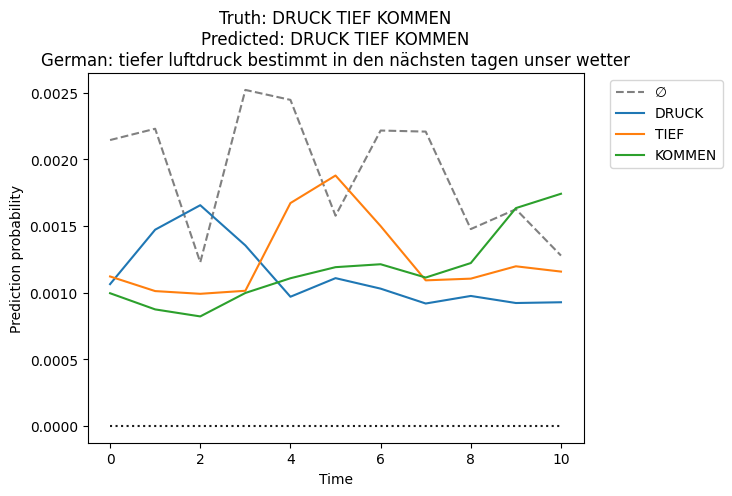

In [13]:
def plot_data(data_item, normalize=True, key='sequence_logits', show_other_labels=False):
    output_data = data_item[key][:, 0, :]
    if normalize:
        output_data = output_data - np.min(output_data)
        output_sum = np.sum(output_data, axis=1)
        output_data = output_data / output_sum.reshape((len(output_sum), 1))
    labels = data_item['labels']
    anotation_data = data_item["annotations"][0].split("|")
    labels_gloss = anotation_data[-2].split(' ')
    predicted = ' '.join([w for w, n in data_item["predictions"][0]])
    
    plt.plot(output_data[:, 0], '--', color="grey")
    plt.plot(output_data[:, labels])
    if show_other_labels:
        plt.plot(output_data, color=(.3,.3,.3,.1))
    plt.plot((0, output_data.shape[0]-1), (0, 0), ':', color=(.1,.1,.1))
    
    plt.title(f"Truth: {anotation_data[-2]}\nPredicted: {predicted}\nGerman: {anotation_data[-1]}")
    plt.legend(['∅'] + labels_gloss, bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel('Time')
    plt.ylabel('Prediction probability')
    plt.show()
    
plot_data(ret_data[idx])

In [14]:
def stack_data(ret_data, seq_len=119, label_len=30):
    seq_shape, label_shape = (seq_len, 1116), (label_len)
    modes = ["dev", "test", "train"]
    save_keys = ["sequence_logits", "labels", "glosses", "translation", "predictions"]
    modes_dict = {m:{k:[] for k in save_keys} for m in modes}
    
    for m in modes:
        print(f"Mode: {m}")
        for data in tqdm(ret_data[:]):
            if not data["mode"] == m:
                continue
            annotations = data["annotations"][0].split("|")
            seq_logits = np.pad(
                data["sequence_logits"][:,0,:], 
                [(0, seq_len-data["sequence_logits"].shape[0]),(0,0)])
            labels = np.array(data["labels"])
            labels = np.pad(labels, ((0,label_len-labels.shape[0])))
                
            modes_dict[m]["sequence_logits"].append(seq_logits)
            modes_dict[m]["labels"].append(labels)
            modes_dict[m]["glosses"].append(annotations[-2])
            modes_dict[m]["translation"].append(annotations[-1])
            modes_dict[m]["predictions"].append(" ".join([d[0] for d in data["predictions"][0]]))
        modes_dict[m]["sequence_logits"] = np.stack(modes_dict[m]["sequence_logits"])
        modes_dict[m]["labels"] = np.vstack(modes_dict[m]["labels"])    
    return modes_dict

ret = stack_data(ret_data)

Mode: dev


  0%|          | 0/8206 [00:00<?, ?it/s]

Mode: test


  0%|          | 0/8206 [00:00<?, ?it/s]

Mode: train


  0%|          | 0/8206 [00:00<?, ?it/s]

In [ ]:
def save_stacked_data(ret_data):
    modes = ["train", "dev", "test"]
    for m in modes:
        ret = ret_data[m]
        print(ret["sequence_logits"].shape)
        print(ret["labels"].shape)
        print(len(ret["glosses"]))
        print(len(ret["translation"]))
        print(len(ret["predictions"]))
        
        base_dir = f"./json_saved_data/{m}/"
        seq_filename = base_dir + f"sequence_logits_{m}.npy"
        label_filename = base_dir + f"labels_{m}.npy"
        np.save(seq_filename, ret["sequence_logits"])
        np.save(label_filename, ret["labels"])
        with open(base_dir + f"tlp_output_{m}.json", "w+") as f:
            json.dump({
                "sequence_logits": seq_filename,
                "labels": label_filename,
                "glosses": ret["glosses"],
                "translations": ret["translation"],
                "predictions": ret["predictions"],
            }, f)

save_stacked_data(ret)

(7045, 119, 1116)
(7045, 30)
7045
7045
7045


In [ ]:
def check_data(m="train"):
    base_dir = f"../fpt4slt/data/probs/"
    file_name = f"tlp_output_{m}.json"
    with open(base_dir + file_name, "r") as f:
        data = json.load(f)
        logits = np.load(base_dir + data['sequence_logits'].split("/")[-1])
        return data, logits
dev_data, dev_logits = check_data("dev")
test_data, test_logits = check_data("test")
train_data, train_logits = check_data("train")

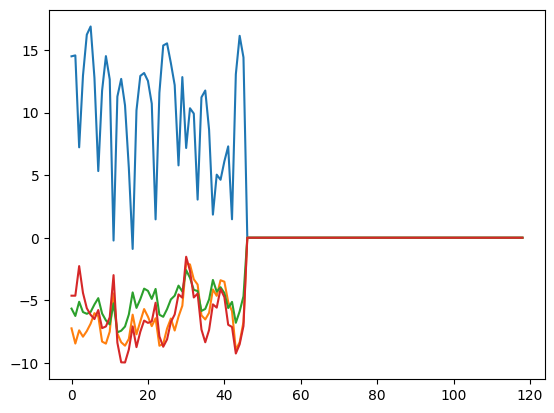

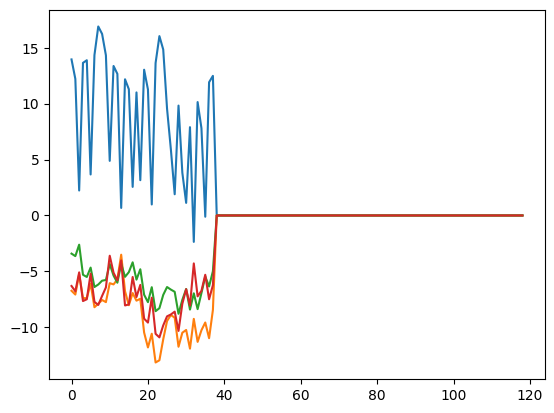

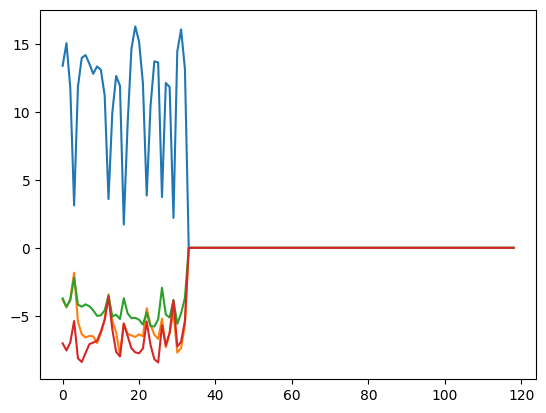

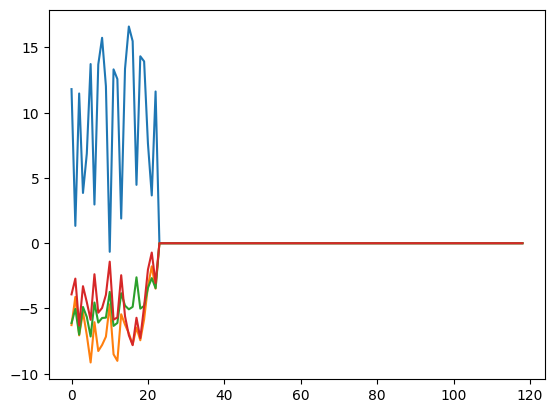

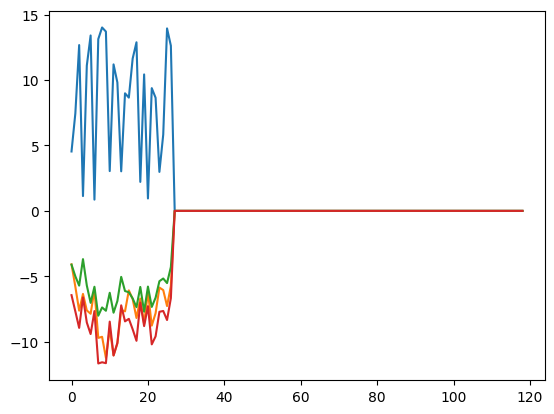

In [13]:
for i in [0,1,19,14,200]:
    plt.plot(test_logits[i,:,[0,1,2,3]].T)
    plt.show()